In [26]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from scipy.ndimage import generic_filter

from hsdfmpm.mpm import AutofluorescenceImage, LifetimeImage, OpticalRedoxRatio, InstrumentResponseFunction
from hsdfmpm.utils import colorize, truncate_colormap
from hsdfmpm.mpm.flim.utils import (
    get_phasor_coordinates,
    cartesian_from_lifetime,
    phasor_svd,
    find_intersection_with_circle,
    project_to_line,
    get_endpoints_from_projection,
    lifetime_from_cartesian,
    plot_universal_circle,
    convert_vT_to_point_slope, fit_phasor
)

In [27]:
# This creates the IRF model, then stores/updates it in the .hsdfm data to be reused.
InstrumentResponseFunction.load(
    path=r'\\deckard\bmeg\Rajaram-Lab\Ivers,Jesse\Codes\matlab\Toolbox\ImageProcessing\MPM_Processing\FLIM Code\IRF Files\Raw\Upright_I_IRF.sdt', reference_lifetime=0, channels=0
).store()
decay = LifetimeImage(image_path=r'E:\new df\POC Study\Animals\1675NT\03302025\21\fov1\fov1_flim_755-094', channels=0)
decay.load_irf()

C:\Users\jdivers\PycharmProjects\hsdfmpm\src\hsdfmpm\mpm\flim\flim.py:75: Warning: Loading default IRF file, 'C:\Users\jdivers\.hsdfmpm\irf\irf.pkl'.
  self.calibration = get_irf(irf)


C:\Users\jdivers\AppData\Local\miniconda3\envs\image_fitting\Lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: All-NaN slice encountered
  _nd_image.generic_filter(input, function, footprint, output, mode,


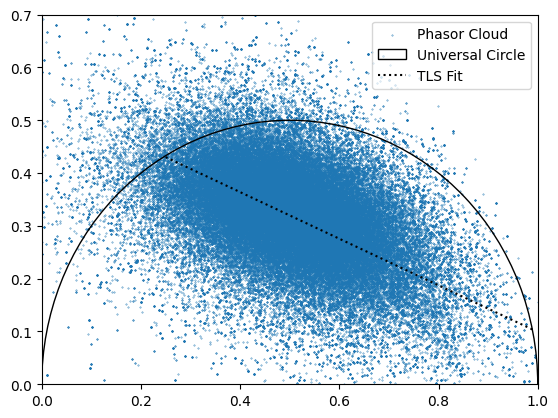

In [28]:
kwargs = dict(threshold=10, median_filter_count=1, k_size=3, correction=True)
g, s = decay.phasor_coordinates(**kwargs)
x, y = decay.get_phasor_line(**kwargs)['intersection']
plt.scatter(g, s, s=0.1, label='Phasor Cloud')
plot_universal_circle(omega=decay.omega)
plt.plot(x, y, linestyle=':', color='k', label='TLS Fit')
plt.xlim(0, 1)
plt.ylim(0, 0.7)
plt.legend()
plt.show()

C:\Users\jdivers\AppData\Local\miniconda3\envs\image_fitting\Lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: All-NaN slice encountered
  _nd_image.generic_filter(input, function, footprint, output, mode,


Lifetimes from fit. Free 0.2091ns, Bound: 3.472ns


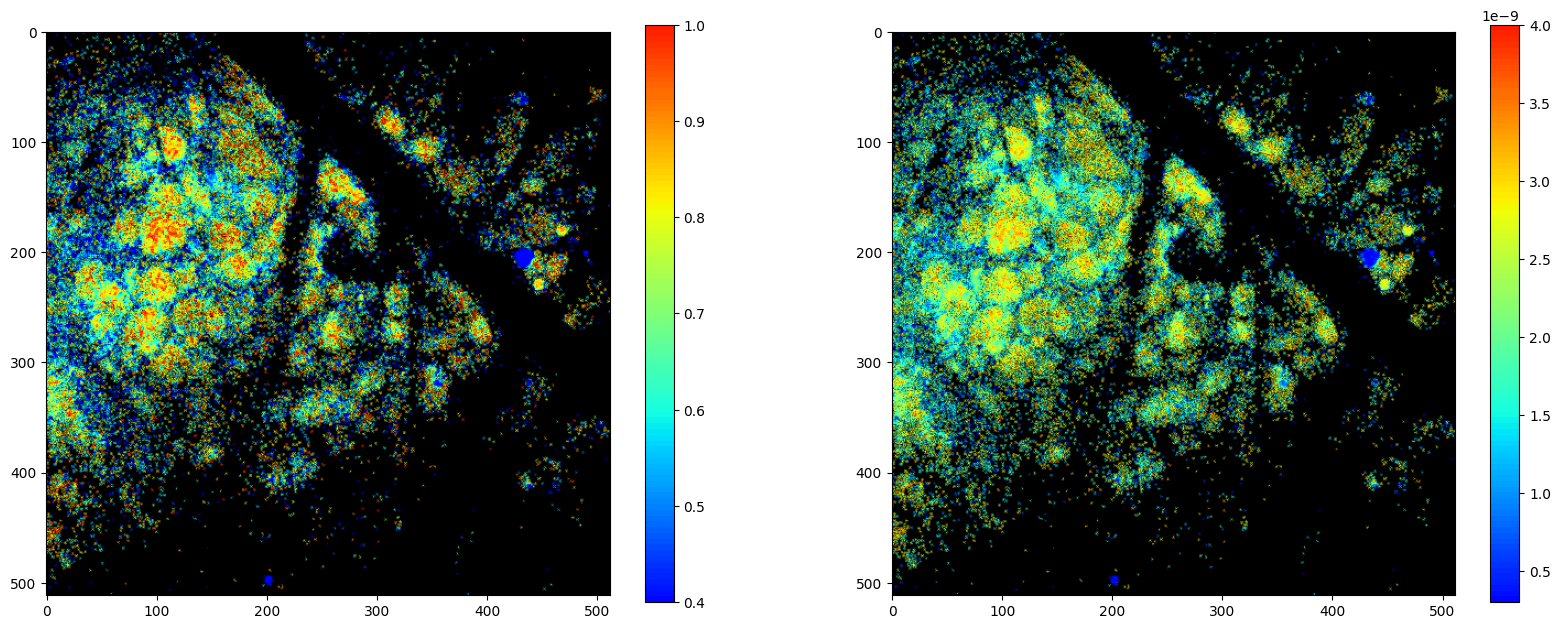

In [29]:
alphas, taum, tau = decay.fit_for_lifetime_approximations(threshold=10, median_filter_count=1, k_size=3, correction=True)
a2_frac = alphas[1] / np.sum(alphas, axis=0)

print(f'Lifetimes from fit. Free {tau[0].item() * 1e9:.4g}ns, Bound: {tau[1].item() * 1e9:0.4g}ns')
fig, ax = plt.subplots(1, 2, figsize=(20, 7.5))

cmap = truncate_colormap('jet', cmin=0.13, cmax=0.88)
color_a2, cmap = colorize(a2_frac.squeeze(), decay.photons.squeeze(), cmap=cmap, cmin=0.4, cmax=1)
ax[0].imshow(color_a2, cmap=cmap)
sm = plt.cm.ScalarMappable(norm=Normalize(vmin=0.4, vmax=1), cmap=cmap)
plt.colorbar(sm, ax=ax[0])

cmap = truncate_colormap('jet', cmin=0.13, cmax=0.88)
color_tm, cmap = colorize(taum.squeeze(), decay.photons.squeeze(), cmap=cmap, cmin=1e-9, cmax=4e-9)
plt.imshow(color_tm, cmap=cmap)
sm = plt.cm.ScalarMappable(norm=Normalize(vmin=0.3e-9, vmax=4e-9), cmap=cmap)
plt.colorbar(sm, ax=ax[1])

plt.show()

## Under the hood
The LifetimeImage object handles a lot of logic. Below walks through the same steps, with slightly less abstraction, to clarify what is going on under the hood of the lifetime object. The results are the same; the object methods make for simpler flow, while the individual functions allow intermediate values to be played with.

C:\Users\jdivers\AppData\Local\miniconda3\envs\image_fitting\Lib\site-packages\scipy\ndimage\_filters.py:1963: RuntimeWarning: All-NaN slice encountered
  _nd_image.generic_filter(input, function, footprint, output, mode,


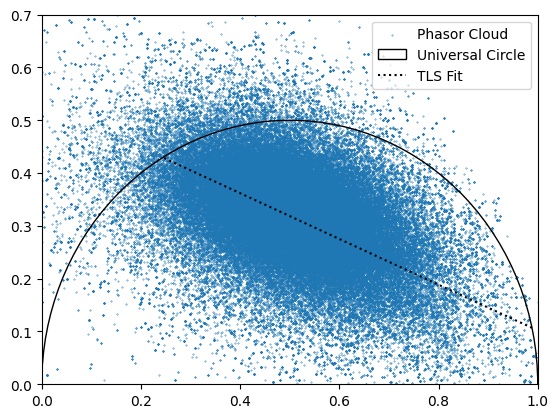

In [30]:
P, photons = get_phasor_coordinates(decay.raw, as_complex=True, frequency=decay.frequency, bin_width=decay.bin_width)
P[photons < 10] = np.nan
P_irf, _ = get_phasor_coordinates(decay.calibration.raw, as_complex=True, frequency=decay.calibration.frequency, bin_width=decay.calibration.bin_width)
P_corr = cartesian_from_lifetime(decay.calibration.reference_lifetime, 2 * np.pi * decay.calibration.frequency, as_complex=True) / P_irf
P *= P_corr
g, s = P.real, P.imag
g = generic_filter(g, np.nanmedian, size=3, mode='nearest')
s = generic_filter(s, np.nanmedian, size=3, mode='nearest')
b, m = fit_phasor(g, s)
x, y = find_intersection_with_circle(b, m)

plt.scatter(g, s, s=0.1, label='Phasor Cloud')
plot_universal_circle(omega=decay.omega)
plt.plot(x, y, linestyle=':', color='k', label='TLS Fit')
plt.xlim(0, 1)
plt.ylim(0, 0.7)
plt.legend()
plt.show()

In [31]:
mask = ~(np.isnan(g) | np.isnan(s))
vT, ratio, mu = phasor_svd(g[mask], s[mask])
b, m = convert_vT_to_point_slope(vT, mu)

x, y = find_intersection_with_circle(b, m)
gp, sp = project_to_line(g, s, x, y)
tau = lifetime_from_cartesian(x, y, decay.omega)
alphas, taum = get_endpoints_from_projection(gp, sp, x, y, tau)
a2_frac = alphas[1] / np.sum(alphas, axis=0)

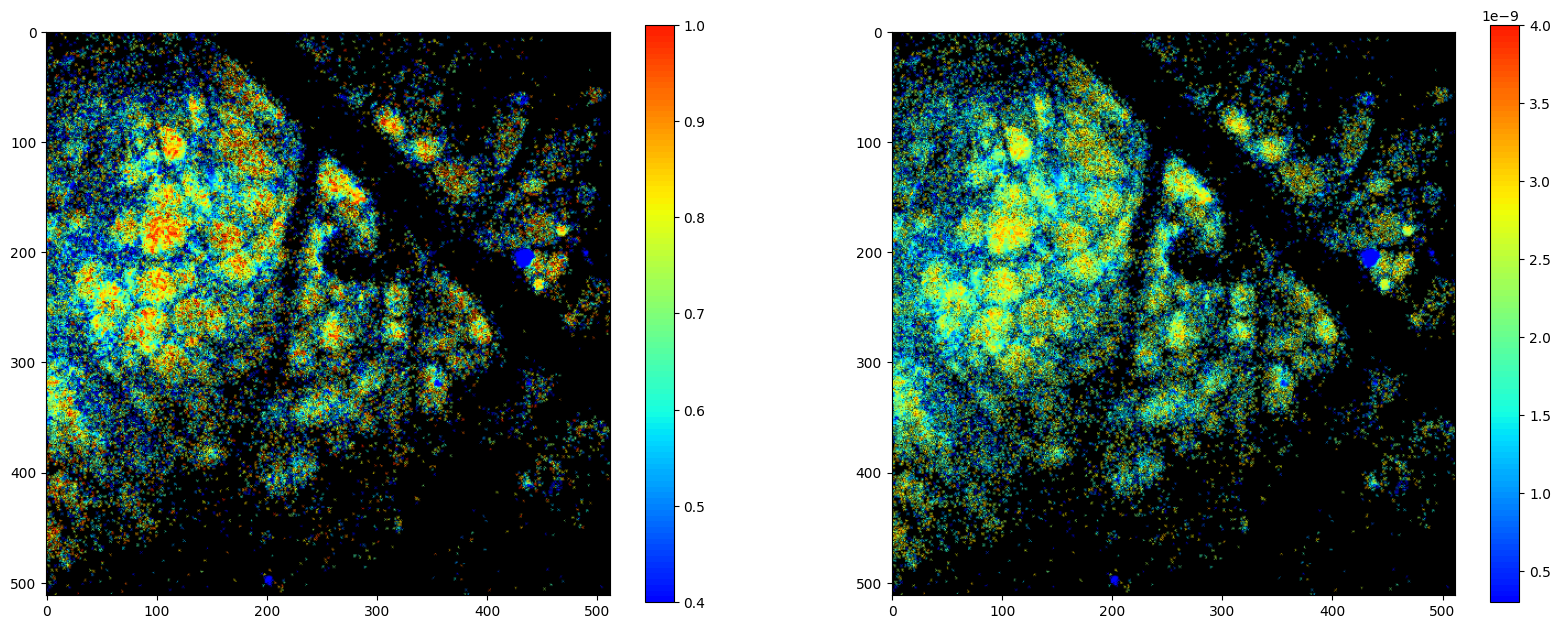

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7.5))

cmap = truncate_colormap('jet', cmin=0.13, cmax=0.88)
color_a2, cmap = colorize(a2_frac.squeeze(), photons.squeeze(), cmap=cmap, cmin=0.4, cmax=1)
ax[0].imshow(color_a2, cmap=cmap)
sm = plt.cm.ScalarMappable(norm=Normalize(vmin=0.4, vmax=1), cmap=cmap)
plt.colorbar(sm, ax=ax[0])

cmap = truncate_colormap('jet', cmin=0.13, cmax=0.88)
color_tm, cmap = colorize(taum.squeeze(), photons.squeeze(), cmap=cmap, cmin=1.25e-9, cmax=4e-9)
plt.imshow(color_tm, cmap=cmap)
sm = plt.cm.ScalarMappable(norm=Normalize(vmin=0.3e-9, vmax=4e-9), cmap=cmap)
plt.colorbar(sm, ax=ax[1])

plt.show()

# ORR
Processing ORRs from excitation images is simple. AF Image objects can be made explicitly and loaded into the ORR object, or the paths can be passed to the ORR object along with a power directory. The ORR object handles normalization automatically, meaning it is ready to use as soon as the object is created!

In [33]:
ex755 = AutofluorescenceImage(image_path=r'E:\new df\POC Study\Animals\1675NT\03302025\21\fov1\fov1_redox_755-095', power_file_path=r'E:\new df\POC Study\LaserPower')
ex855 = AutofluorescenceImage(image_path=r'E:\new df\POC Study\Animals\1675NT\03302025\21\fov1\fov1_redox_855-096', power_file_path=r'E:\new df\POC Study\LaserPower\power03312025.xlsx')
orr = OpticalRedoxRatio(ex755=ex755, ex855=ex855)

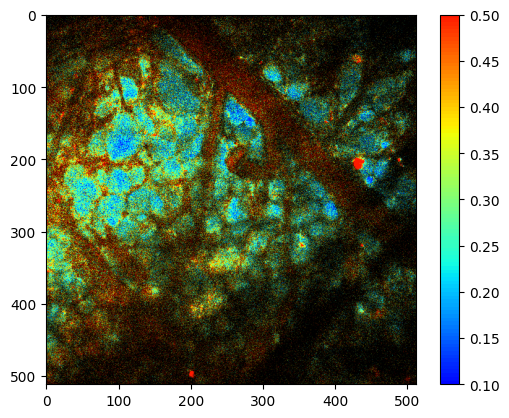

In [34]:
cmap = truncate_colormap('jet', cmin=0.13, cmax=0.88)
color_orr, cmap = orr.colorize(cmap=cmap, cmin=0.1, cmax=0.5)
plt.imshow(color_orr, cmap=cmap)
sm = plt.cm.ScalarMappable(norm=Normalize(vmin=0.1, vmax=0.5), cmap=cmap)
plt.colorbar(sm, ax=plt.gca())
plt.show()